# Draft 1: Beginning of Season Hurricane Forecasting
Objective: Predict the number of named storms that will occur in a given season based on prevailing conditions in May of that year (the time of year when many hurricane forecasts are released).

In [89]:
import pandas as pd
import numpy as np
from time import process_time

In [150]:
nstorms = pd.read_csv('data/nstorms_byyear.csv')
nstorms.head()

,Unnamed: 0,year,TS,HU,TOTAL
0,0,1950,3,11,14
1,1,1951,3,8,11
2,2,1952,2,5,7
3,3,1953,2,7,9
4,4,1954,3,6,9


In [151]:
midgulf = pd.read_csv('data/1975to2023_MidGulf_buoydata.csv')
midgulf.head()

,Unnamed: 0,YY,MM,DD,hh,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS
0,0,2023,1,16.000448,11.501456,134.401937,6.347220,8.104596,1.308026,6.209131,4.857487,144.777325,1017.862469,22.861143,24.196882,19.596565,NaN
1,1,2023,2,14.500000,11.500000,150.220950,6.900868,8.811039,1.390223,6.526369,4.900804,151.238628,1020.280704,23.235624,24.985757,20.216073,NaN
2,2,2023,3,16.000000,11.500000,123.338292,7.162489,9.010291,1.291415,6.073982,4.643875,128.785521,1017.147110,24.463543,26.135011,21.566121,NaN
3,3,2023,4,15.488151,11.527649,139.341902,6.525668,8.246106,1.367727,6.616688,4.941960,128.665260,1017.065125,25.136628,26.035371,22.323848,NaN
4,4,2023,5,16.000000,11.500000,138.880381,4.597848,5.881398,0.735773,5.382695,4.131866,133.090763,1027.067137,26.550651,27.315691,23.466659,NaN


In [163]:
oni = pd.read_csv('data/Monthly_Nino_3.4_Index.csv')
# Note that we filter to the month of May here:
oni2 = oni[oni['month']==5].drop(['Unnamed: 0','month','ONI_climAdjust'],axis=1).set_index('year')
oni2.head()

,ONI_total,ONI_anom
year,,
1950,26.19,-1.37
1951,27.93,0.37
1952,27.79,0.23
1953,28.28,0.71
1954,27.11,-0.45


In [162]:
df = pd.merge(nstorms[nstorms['year']>= 1976], midgulf[midgulf['MM']==5], left_on = 'year', right_on = 'YY', how = 'inner').set_index('year')
df = df.drop(['YY','MM','DD','hh','Unnamed: 0_x','Unnamed: 0_y'],axis=1)
df = pd.merge(df, oni2, left_on = 'year', right_on = 'year', how = 'left')
df.head()

,TS,HU,TOTAL,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,ONI_total,ONI_anom
year,,,,,,,,,,,,,,,,,
1976,2,6,8,126.619048,5.714488,NaN,0.889695,NaN,4.515267,NaN,1043.881690,23.702120,25.060071,21.877273,NaN,27.20,-0.31
1977,1,5,6,145.346154,4.367308,NaN,1.204286,NaN,3.095652,NaN,1015.015385,25.011538,25.721154,NaN,NaN,27.72,0.22
1978,6,5,11,137.108871,4.766532,NaN,1.035593,NaN,4.163559,NaN,1013.395181,25.568675,25.269697,NaN,NaN,27.20,-0.31
1979,3,5,8,130.362903,6.003629,NaN,1.189069,NaN,4.242510,NaN,1014.309677,25.319355,25.599588,NaN,NaN,27.69,0.19
1980,2,9,11,138.636119,5.668414,6.839113,0.920699,5.694892,4.516667,NaN,1012.922849,25.641667,25.988844,NaN,NaN,28.02,0.51


In [164]:
# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

In [161]:
unused_cols = ['MWD','DEWP','VIS','TS','HU']
df_nona = df.drop(unused_cols, axis=1).dropna()
X = df_nona.drop(['TOTAL'], axis=1)
y = df_nona['TOTAL']

X.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,ONI_total,ONI_anom
year,,,,,,,,,,,
1980,138.636119,5.668414,6.839113,0.920699,5.694892,4.516667,1012.922849,25.641667,25.988844,28.02,0.51
1981,96.037190,5.459839,6.187149,0.772851,5.301357,4.231222,1668.325506,25.193080,25.567229,27.36,-0.30
1982,102.508796,5.655795,6.417103,1.029111,6.057547,4.724798,1026.751747,27.123149,24.769179,28.39,0.72
1983,115.871448,6.607527,7.613462,1.202423,5.850202,4.611709,1014.156317,25.873790,25.092070,28.84,1.18
1984,110.744565,8.329570,9.638441,1.413978,6.294892,4.780108,1685.159701,24.644892,25.552688,27.20,-0.46


In [136]:

lr = LinearRegression().fit(X, y)
preds = lr.predict(X)
preds

# Try regularization, polynomial features, train/test split, etc. 

array([ 7.96485408,  7.31700518,  5.61202647,  6.45578121, 10.25761799,
       12.57437551, 10.33412275,  8.82320033, 12.41696287, 13.27180004,
       10.77035828, 12.59090642, 11.73838362, 10.95012223, 11.52016413,
       13.54476513,  9.02470693, 16.18559243, 13.65994187, 12.47428978,
       13.40615671, 11.47065322, 13.78625136, 13.87545124, 13.63710271,
       16.86157257, 14.55458702, 17.38884259, 16.12859114, 16.11253174,
       10.91971243, 14.32117915, 15.57127215, 15.69946853, 17.77965019])

In [137]:
pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])
pipe_lasso.fit(X,y)
preds_lasso = pipe_lasso.predict(X)
preds_lasso

array([11.87649357, 12.22445665, 10.504515  , 10.38739721, 12.35948919,
       14.28548523, 12.13867692, 11.60560071, 12.31988214, 14.06427763,
       12.18216327, 12.50746846, 11.29447466, 12.40146288, 12.9003416 ,
       12.56975495, 10.76286026, 14.56809148, 13.53189028, 12.2236623 ,
       12.44289222, 11.48881623, 12.30163017, 13.06159116, 12.65314827,
       13.58523379, 12.33516407, 13.87009053, 13.15626293, 12.54354961,
       12.67252111, 12.59736637, 11.91525366, 13.84169582, 13.82633967])

In [138]:
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
pipe_ridge.fit(X,y)
preds_ridge = pipe_ridge.predict(X)
preds_ridge

array([10.92454175,  7.64515343,  5.42993321,  7.08375741, 11.07203691,
       12.26416384, 11.73323616,  9.65464185, 12.79355391, 14.60728541,
       11.95588323, 13.18761079, 12.09001565, 10.53167636, 12.34750011,
       13.40432084,  8.45801296, 16.59414236, 14.07881193, 12.73990139,
       13.76404917, 10.53757433, 13.53414808, 13.61952875, 12.64875129,
       16.07504106, 13.67365368, 16.86642887, 14.90922071, 15.05348587,
       10.69438704, 13.12175805, 13.42628708, 15.84719025, 16.6323163 ])

In [139]:
y_preds = df_nona[['TOTAL']].copy().reset_index().rename(columns = {'TOTAL':'actual'})
baseline = np.mean(y_preds['actual'])
y_preds['baseline'] = baseline
y_preds['predicted'] = preds
y_preds['lasso'] = preds_lasso
y_preds['ridge'] = preds_ridge
y_preds.head()

,year,actual,baseline,predicted,lasso,ridge
0,1980,11,12.542857,7.964854,11.876494,10.924542
1,1981,11,12.542857,7.317005,12.224457,7.645153
2,1982,5,12.542857,5.612026,10.504515,5.429933
3,1983,4,12.542857,6.455781,10.387397,7.083757
4,1984,12,12.542857,10.257618,12.359489,11.072037


In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

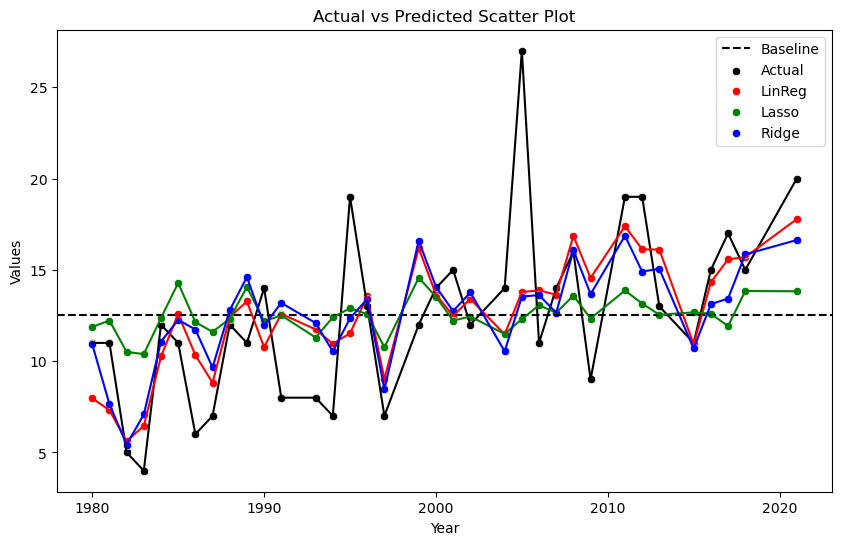

In [141]:
plt.figure(figsize=(10, 6))

plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')

# Plot the actual values
sns.scatterplot(data=y_preds, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds, x='year', y='predicted', color='red', label='LinReg')
sns.lineplot(data=y_preds, x='year', y='predicted', color='red')

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds, x='year', y='ridge', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Actual vs Predicted Scatter Plot')
plt.legend()

# Display the plot
plt.show()

Note: I expect that these (particularly the LinReg and barely-regularized Ridge analysis) are way overfit and would not do well on new data. This is a major challenge for this problem -- given the limited number of samples due to good data only going back 50 or so years, it may be difficult to create a predictive model that doesn't overfit.

#### Mean Squared Error

In [142]:
mse_baseline = mean_squared_error(y_preds['actual'],y_preds['baseline'])
print(mse_baseline)

22.362448979591836


In [143]:
mse_lr = mean_squared_error(y_preds['actual'],y_preds['predicted'])
print(mse_lr)

13.11469740561943


In [144]:
mse_lasso = mean_squared_error(y_preds['actual'],y_preds['lasso'])
print(mse_lasso)

18.929058590324402


## Same models with GridSearchCV and a Test/Train split:
- Train Test split with a test size of 30% of the data (realizing that there may not be enough total samples to safely split the data like this...)
- PolynomialFeatures with degree = 3
- Scaling with StandardScaler()
- Grid search for best hyperparameters for Lasso and Ridge (alpha term that controls amount of regularization)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [153]:
def run_grid(model_setup, N_JOBS = 1, N_CV = 5):
    start = process_time()
    
    # Make Pipeline
    pipe = Pipeline([
        #('preprocessor',preprocessor),
        ('poly', PolynomialFeatures(degree = 3)),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train r2': [grid.score(X_train, y_train)],
               'test r2': [grid.score(X_test, y_test)],
                'train mse': [mean_squared_error(y_train, y_train_preds)],
                'test mse': [mean_squared_error(y_test, y_test_preds)]
               }
    res_df = pd.DataFrame(res_dict)

    feature_names = best_model.named_steps['poly'].get_feature_names_out()
    coefs = best_model.named_steps[model_setup.get('name')].coef_
    coef_df = pd.DataFrame({'feature':feature_names, 'coef':coefs})

    end = process_time()
    print('total time to run: ',end - start)
    
    return(res_df, best_model, coef_df)

In [154]:
model_setup_linreg = {
    'name':'linreg',
    'param_dict':{},
    'model': LinearRegression()
}
results_linreg, _, _ = run_grid(model_setup_linreg, N_JOBS = 2)
results_linreg

total time to run:  0.0530249999999981


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{},-64.985418,0.004164,1.0,-14.067463,1.425866e-27,120.041608


In [159]:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'lasso__alpha':[0.001,0.01,0.1,1,10,100],'lasso__max_iter':[100000]},
    'model': Lasso()
}
results_lasso, _, coefs_lasso = run_grid(model_setup_lasso, N_JOBS = 2)
results_lasso

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.202e-01, tolerance: 5.378e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.027e-01, tolerance: 6.200e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.536e-01, toler

total time to run:  0.024682999999996014


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 100000}",-0.130808,0.001125,0.396332,-0.337913,16.735023,10.659079


In [160]:
model_setup_ridge = {
    'name':'ridge',
    'param_dict':{'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10,100,1000]},
    'model': Ridge()
}
results_ridge, _, coefs_ridge = run_grid(model_setup_ridge, N_JOBS = 2)
results_ridge

total time to run:  0.032770999999996775


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,{'ridge__alpha': 1000},-0.089673,0.001528,0.309905,-0.209382,19.130971,9.635074


# Results
Take a look at the test r2 for lasso and ridge regression above. We have no confidence that this model is working correctly (r^2 < 0!!).

Because of this outcome, I've decided to do a different type of forecast: using monthly atmospheric/climatological data to forecast number of storms in that month. This effectively 12x the available data since we can use monthly rather than only May data.

### Were the models better at predicting Number of Storms or ACE?

Hypothesis: The models will be better at predicting Accumulated Cyclone Energy (ACE) than Number of Storms. In other words, I am hypothesizing that the data we are using (El Nino index and sea surface temperature data) will better predict the overall strength and duration of storms in a season (since sea surface temperatures are known to drive and sustain hurricanes) than number of storms (which is a smaller, more discrete, perhaps more random number to predict, and influenced by many factors beyond sea surface temperatures.